In [1]:
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import PIL
from torchvision import transforms
import kaggle
import torchvision

In [2]:
project_dir = Path(".").resolve().parents[0]
project_dir.name

'mlops_project'

In [3]:
class CatDogDataset(Dataset):       
    def __init__(self, split, in_folder, out_folder, transform=None):
        super().__init__()
        
        self.in_folder = in_folder
        self.out_folder = out_folder
        
        if not (in_folder / "data").exists():
            print('Downloading data from Kaggle')
            self.download_raw_data(in_folder)
            
            
        self.split = split
        self.df = self.prepare_dataframe(split)
        self.file_names = self.df['filename'].values
        self.labels = self.df['label'].values
        self.category = self.df['category'].values

        self.transform = transform
        
    def download_raw_data(self, download_path):
        """
        Downloads raw data from Kaggle. 
        Make sure to setup your access token using https://adityashrm21.github.io/Setting-Up-Kaggle/
        """
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files('alifrahman/dataset-for-wbc-classification', path=download_path, unzip=True)
        
    def prepare_dataframe(self, split):
        categories = []
        filenames = []
        SEED = 42
        le = preprocessing.LabelEncoder()

        if split == "train":
            for dogfile in os.listdir(self.in_folder / "data" / "train" / "dogs"):
                categories.append("dogs")
                filenames.append(dogfile)
            for catfile in os.listdir(self.in_folder / "data" / "train" / "cats"):
                categories.append("cats")
                filenames.append(catfile)

            df_train = pd.DataFrame({'filename' : filenames , 'category' : categories})
            df_train['label'] = le.fit_transform(df_train['category'])
            df_train = df_train.sample(frac = 1, random_state = SEED).reset_index(drop=True)
            return df_train

        else:
            for dogfile in os.listdir(self.in_folder / "data" / "validation" / "dogs"):
                categories.append("dogs")
                filenames.append(dogfile)
            for catfile in os.listdir(self.in_folder / "data" / "validation" / "cats"):
                categories.append("cats")
                filenames.append(catfile)

            df_val = pd.DataFrame({'filename' : filenames , 'category' : categories})

            le = preprocessing.LabelEncoder()
            df_val['label'] = le.fit_transform(df_val['category'])
            df_val = df_val.sample(frac = 1, random_state = SEED).reset_index(drop=True)

            df_val, df_test = train_test_split(df_val, test_size = 0.5, random_state = SEED)
            df_val.reset_index(drop = True, inplace = True)
            df_test.reset_index(drop = True, inplace = True)

        if split == "validation":
            return df_val
        elif split == "test":
            return df_test
        else:
            print('split can be either "train", "validation" or "test"')
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        folder = "train" if self.split == "train" else "validation"
        img = PIL.Image.open(self.in_folder / "data" / folder / self.category[idx] / self.file_names[idx])
        
        if self.transform:
            img = self.transform(img)
            
        img = np.asarray(img)
        return img, self.labels[idx]



In [4]:
image_size = 224

data_resize = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

train_dataset = CatDogDataset(split="train", in_folder=Path("../data/raw"), out_folder=Path('../data/processed'), transform=data_resize)
validation_dataset = CatDogDataset(split="validation", in_folder=Path("../data/raw"), out_folder=Path('../data/processed'), transform=data_resize)
test_dataset = CatDogDataset(split="test", in_folder=Path("../data/raw"), out_folder=Path('../data/processed'), transform=data_resize)

train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size = 32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=True)

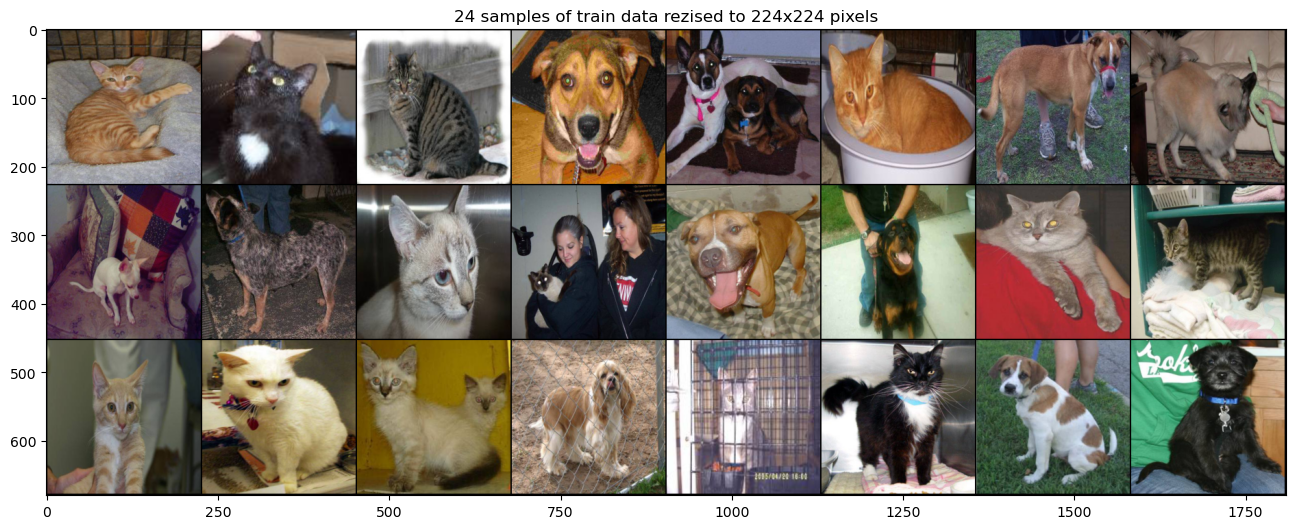

In [5]:
samples, labels = next(iter(train_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.title("24 samples of train data rezised to 224x224 pixels")
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()

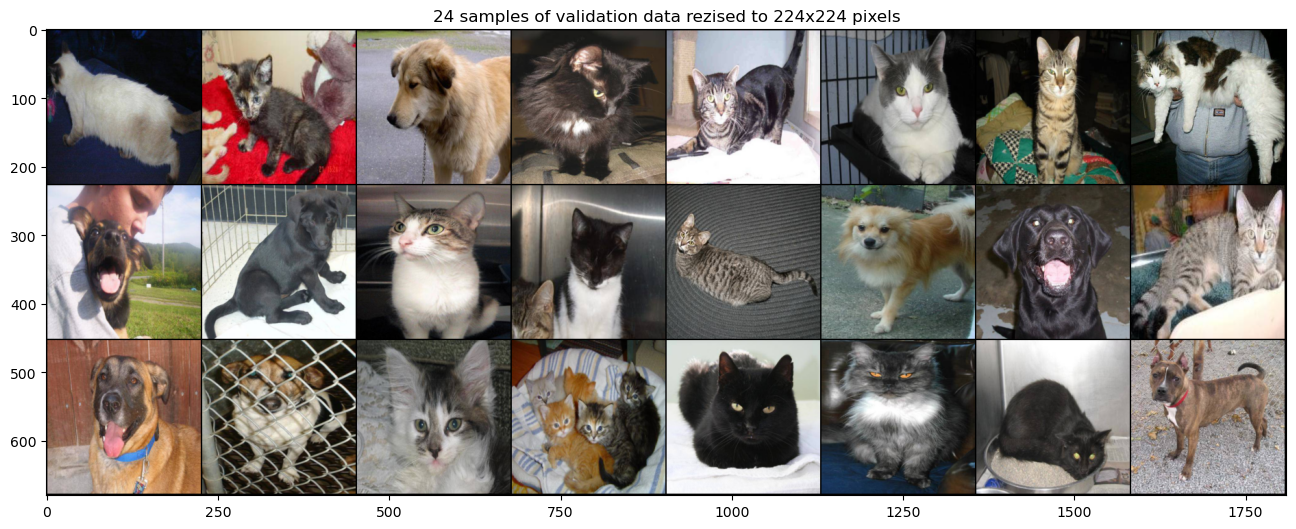

In [6]:
samples, labels = next(iter(validation_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.title("24 samples of validation data rezised to 224x224 pixels")
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()

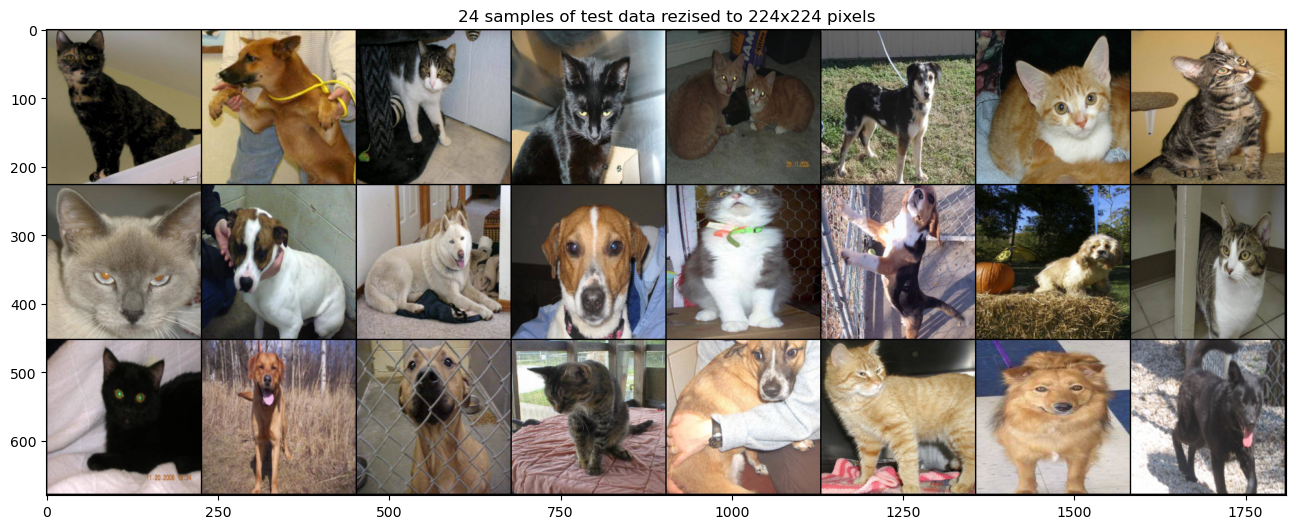

In [7]:
samples, labels = next(iter(test_dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.title("24 samples of test data rezised to 224x224 pixels")
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()